<a href="https://colab.research.google.com/github/mc-robinson/random/blob/master/pytorch_and_fastai_molecular_tabular_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempting to use molecular data with fastai/pytorch

In [1]:
# must use new version of pandas to correctly work with pkl
!pip install pandas==0.24.1

    100% |████████████████████████████████| 10.1MB 4.1MB/s 
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


In [0]:
# after restarting the runtime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import torch
import fastai
from fastai.tabular import *

In [5]:
# Doing work so we can access data from Google drive
# Note that a brief authorization step is necessary 
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Now download the csv, which I have made shareable via google drive
# note that the id is the ending part of the shareable link url (after open?id=)
download = drive.CreateFile({'id': '1uc0dI2z0bPYuW2ptOM5M1cFQqXM2eXto'})
download.GetContentFile('acidic_pka_df.csv')

In [7]:
pka_df = pd.read_csv('acidic_pka_df.csv')
pka_df.head()

,pka,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,...,bit_2038,bit_2039,bit_2040,bit_2041,bit_2042,bit_2043,bit_2044,bit_2045,bit_2046,bit_2047
0,6.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# do a 80, 10, 10 split
train_df, valid_df, test_df = np.split(
  pka_df.sample(frac=1, random_state=42),
  [int(0.80*len(pka_df)), int(0.90*len(pka_df))]  
)

In [0]:
X_train = train_df.values[:,1:]
y_train = train_df.values[:,0]

X_valid = valid_df.values[:,1:]
y_valid = valid_df.values[:,0]

X_test = test_df.values[:,1:]
y_test = test_df.values[:,0]

## Test first on simple GBRT to make sure we are still getting decent results

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

gbrt=GradientBoostingRegressor(n_estimators=1200)
cv_scores = cross_validate(gbrt,
                            X_train,
                            y_train,
                            cv=5,
                            n_jobs=-1,
                            verbose=1,
                            scoring=('r2',
                                     'neg_mean_squared_error',
                                     'neg_mean_absolute_error'
                                    )
                           )

RMSE_scores = [np.sqrt(-1*x) for x in cv_scores['test_neg_mean_squared_error']]
print('RMSE SCORES: ')
print("scores : ", RMSE_scores)
print("mean score : ", np.mean(RMSE_scores))
print("std of score : ", np.std(RMSE_scores))
print("*** \n")

MAE_scores = [-1*x for x in cv_scores['test_neg_mean_absolute_error']]
print('MAE SCORES: ')
print("scores : ", MAE_scores)
print("mean score : ", np.mean(MAE_scores))
print("std of score : ", np.std(MAE_scores))
print("*** \n")

R2_scores = [x for x in cv_scores['test_r2']]
print('R2 SCORES: ')
print("scores : ", R2_scores)
print("mean score : ", np.mean(R2_scores))
print("std of score : ", np.std(R2_scores))
print("*** \n")



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RMSE SCORES: 
scores :  [1.6357666571303213, 1.6783677964150685, 1.7007269114580084, 1.7064788461821214, 1.5458119901616856]
mean score :  1.653430440269441
std of score :  0.05927343642253695
*** 

MAE SCORES: 
scores :  [1.0580081902627156, 1.0924296587616849, 1.1374271945619485, 1.120014759336326, 1.0076458444439893]
mean score :  1.083105129473333
std of score :  0.04631223258156623
*** 

R2 SCORES: 
scores :  [0.7661684296745983, 0.7592304386307097, 0.7591569480001092, 0.7508429720172429, 0.7900681225151075]
mean score :  0.7650933821675536
std of score :  0.013398379973435872
*** 



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.4min finished


### Good, the simple GBRT model with no hyperameter opimization does alright

# Now let's try some neural network approaches with pytorch and fastai:

In [0]:
X_train, y_train, X_valid, y_valid, X_test, y_test = \
map(
  partial(torch.tensor, dtype=torch.float),
  (X_train, y_train, X_valid, y_valid, X_test, y_test)
)

In [0]:
bs = 64
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

### First create a really simple architecture with 2 hidden layers (256 nodes each). I'll also add the capability for some dropout because that is what seemed to work with Deepchem.

### I was able to get pretty good results with this neural net and Deepchem, also another paper mentioned good results (slightly better than the GBRT) with a neural net in Matlab of similar architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Simple_DNN(nn.Module):
  def __init__(self, num_features):
    super(Simple_DNN, self).__init__()
    
    # DEFINE CONSTANTS
    HIDDEN_DIM = 256
    DROPOUT_PCT = 0.0
    
    # implement two hidden layers
    self.fc1 = nn.Linear(num_features, HIDDEN_DIM)
    self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
    self.fc3 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
    self.fc4 = nn.Linear(HIDDEN_DIM, 1)
    self.dropout = nn.Dropout(p=DROPOUT_PCT)
    
  def forward(self, xb):
    xb = F.relu(self.fc1(xb))
    xb = self.dropout(xb)
    xb = F.relu(self.fc2(xb))
    xb = self.dropout(xb)
    xb = F.relu(self.fc3(xb))
    xb = self.fc4(xb)
    return xb

In [0]:
# use fastai for finding the learning rate and the training 
# start with no dropout
learn = Learner(data, Simple_DNN(num_features=2048),
                loss_func=nn.MSELoss(),
                metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03


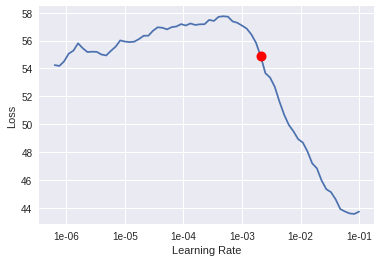

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(50, 1e-02)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,34.967941,19.962160,4.499454,-0.788478
2,20.212530,12.761299,3.677649,-0.190579
3,15.415260,12.576256,3.640672,-0.168179
4,13.370807,11.938014,3.507845,-0.083796
5,12.672885,12.503288,3.558881,-0.117366
6,12.474814,13.612841,3.692712,-0.200505
7,12.832318,17.828043,4.238615,-0.583118
8,13.128378,12.223051,3.480092,-0.066295
9,12.744902,14.078045,3.739795,-0.230882
10,12.562155,12.075440,3.521306,-0.091246


### It's not even overfitting (and there is no dropout). Not getting above R2 score of 0 is really bad.

### Let's see if we can at least get it to overfit with a small number of samples:

In [0]:
small_train_ds = TensorDataset(X_train[0:5], y_train[0:5])
small_valid_ds = TensorDataset(X_valid[0:5], y_valid[0:5])
small_data = DataBunch.create(small_train_ds, small_valid_ds)

In [0]:
# use fastai for finding the learning rate and the training 
# start with no dropout
learn_small_data_test = Learner(small_data, Simple_DNN(num_features=2048),
                loss_func=nn.MSELoss(),
                metrics=root_mean_squared_error)

In [0]:
learn_small_data_test.lr_find()
learn_small_data_test.recorder.plot()

ZeroDivisionError: ignored

### I can't get it to work with any batch size on this small number of samples!

### Ok, I will try another way based on Jeremy's nice pytorch tutorial https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [0]:
from torch import optim

# creat function to fetch the model and optimizer
def get_model(num_features, lr, GPU=False, GPU_dev=None):
  if GPU:
    model = Simple_DNN(num_features)
    return model.to(GPU_dev), optim.SGD(model.parameters(), lr=lr)
  else:
    model = Simple_DNN(num_features)
    return model, optim.SGD(model.parameters(), lr=lr)

# function to calculate the loss, and do opt step in training
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)
  
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
    
  return loss.item(), len(xb)

# function to fit the model for number of epochs given loss func
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)
      
    model.eval()
    with torch.no_grad():
      train_losses, train_nums  = zip(
        *[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl]
      )
      trn_loss = ( 
          np.sum(np.multiply(train_losses, train_nums)) / np.sum(train_nums)
      )
      
      valid_losses, valid_nums  = zip(
        *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
      )
      val_loss = (
          np.sum(np.multiply(valid_losses, valid_nums)) / np.sum(valid_nums)
      )
      
      if epoch % 5 == 0:
        print('epoch: ', epoch, 'train_loss: ', trn_loss, 'valid_loss: ',val_loss)

In [0]:
# creating custom dataloader to use with GPU
class GPUDataLoader:
  def __init__(self, dl, dev):
    self.dl = dl
    self.dev = dev
    
  def __len__(self):
    return len(self.dl)
  
  def __iter__(self):
    batches = iter(self.dl)
    for b in batches:
      yield(self._move_to_GPU(*b))
      
  def _move_to_GPU(self, X, y):
    return X.to(self.dev), y.to(self.dev)

# function that fetches data either on/off GPU
def get_data(train_ds, valid_ds, bs, GPU=False, GPU_dev=None):
  if GPU and GPU_dev is not None:
    # train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True),
    # valid_dl = DataLoader(valid_ds, batch_size=bs*2)
    return (
      GPUDataLoader(DataLoader(train_ds, batch_size=bs, shuffle=True), GPU_dev),
      GPUDataLoader(DataLoader(valid_ds, batch_size=bs*2), GPU_dev)
    )
  else:
    return (
      DataLoader(train_ds, batch_size=bs, shuffle=True),
      DataLoader(valid_ds, batch_size=bs*2)
    )

In [0]:
small_train_ds = TensorDataset(X_train[0:5], y_train[0:5])
small_valid_ds = TensorDataset(X_valid[0:5], y_valid[0:5])

In [0]:
# Finally, train the model!

dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 50
bs = 64
lr = 0.1
loss_func = nn.MSELoss()

# use the small data
small_train_dl, small_valid_dl = get_data(small_train_ds, small_valid_ds,
                              bs, GPU=True, GPU_dev=dev)

model, opt = get_model(num_features=2048, lr=lr, GPU=True, GPU_dev=dev)

fit(epochs, model, loss_func, opt, small_train_dl, small_valid_dl)


epoch:  0 train_loss:  28.1943416595459 valid_loss:  25.76837921142578
epoch:  5 train_loss:  14.899280548095703 valid_loss:  8.270212173461914
epoch:  10 train_loss:  13.446062088012695 valid_loss:  4.915328502655029
epoch:  15 train_loss:  13.446062088012695 valid_loss:  4.915293216705322
epoch:  20 train_loss:  13.446062088012695 valid_loss:  4.915318012237549
epoch:  25 train_loss:  13.446061134338379 valid_loss:  4.915342807769775
epoch:  30 train_loss:  13.446061134338379 valid_loss:  4.9153666496276855
epoch:  35 train_loss:  13.446061134338379 valid_loss:  4.9153900146484375
epoch:  40 train_loss:  13.446061134338379 valid_loss:  4.915412425994873
epoch:  45 train_loss:  13.446061134338379 valid_loss:  4.91543436050415


### Why does that train loss converge, but not go to 0!!!

### Let's try with one sample!

In [0]:
one_sample_train_ds = TensorDataset(X_train[0,:].reshape(1,-1), y_train[[0]])
one_sample_valid_ds = TensorDataset(X_valid[0,:].reshape(1,-1), y_valid[[0]])

In [0]:
# Train the model with just one sample!

dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 50
bs = 64
lr = 0.1
loss_func = nn.MSELoss()

# use the small data
small_train_dl, small_valid_dl = get_data(one_sample_train_ds, one_sample_valid_ds,
                              bs, GPU=True, GPU_dev=dev)

model, opt = get_model(num_features=2048, lr=lr, GPU=True, GPU_dev=dev)

fit(epochs, model, loss_func, opt, small_train_dl, small_valid_dl)

epoch:  0 train_loss:  38.313716888427734 valid_loss:  5.290582180023193
epoch:  5 train_loss:  108.30901336669922 valid_loss:  41.19266128540039
epoch:  10 train_loss:  5091.599609375 valid_loss:  4538.103515625
epoch:  15 train_loss:  546.7064819335938 valid_loss:  376.0401306152344
epoch:  20 train_loss:  58.7021484375 valid_loss:  13.481624603271484
epoch:  25 train_loss:  6.303093433380127 valid_loss:  2.1886346340179443
epoch:  30 train_loss:  0.6767898201942444 valid_loss:  10.031963348388672
epoch:  35 train_loss:  0.07266971468925476 valid_loss:  13.841573715209961
epoch:  40 train_loss:  0.007802910171449184 valid_loss:  15.222994804382324
epoch:  45 train_loss:  0.0008378112688660622 valid_loss:  15.68995475769043


### Well at least that overfit correctly

### Let's see If I can get anywhere better using the fastai tabular learner

In [0]:
# Note that this isn't quite a fair comparison because I am not using 
# the same train/valid/test split! But I am just trying to get something working
data = (TabularList.from_df(pka_df, path='.', 
                            cont_names=list(pka_df.columns)[1:])
        .split_by_idx(valid_idx=range(3000,pka_df.shape[0]))
        .label_from_df(cols='pka')
        .databunch()
       )

In [0]:
learn = tabular_learner(data,
                        layers=[256,256],
                        loss_func=nn.MSELoss(),
                        metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


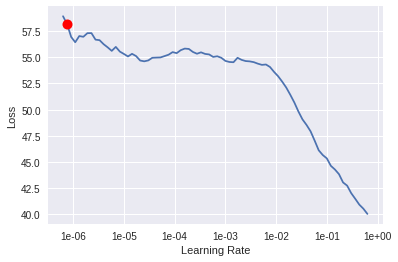

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-02)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,41.227276,31.417316,5.771024,-1.696110
2,20.460962,3798.000000,51.169476,-345.601624
3,14.665569,387016.187500,532.185730,-34736.746094
4,12.632124,328987.281250,504.026215,-29601.400391
5,11.935468,448465.343750,571.947083,-40105.644531


### Wow that looks like clear overfitting since the validation loss shoots way up! But the training error is still not even good...

### There is only one main difference I can think of; in the Deepchem models I had standardized the pka values before training the neural net. Let's see if that helps at all.

In [0]:
# cheating because using all of data for standardization,
# but just want something to work!
pka_df['std_pka'] = (pka_df['pka'] - pka_df['pka'].mean()) / pka_df['pka'].std()

In [0]:
pka_df.head()

,pka,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,...,bit_2039,bit_2040,bit_2041,bit_2042,bit_2043,bit_2044,bit_2045,bit_2046,bit_2047,std_pka
0,6.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.107161
1,5.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.278951
2,5.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.261481
3,5.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.267304
4,9.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789637


In [0]:
# Note that this isn't quite a fair comparison because I am not using 
# the same train/valid/test split! But I am just trying to get something working
data = (TabularList.from_df(pka_df, path='.',
                            cont_names=list(pka_df.columns)[1:-1])
        .split_by_idx(valid_idx=range(3000,pka_df.shape[0]))
        .label_from_df(cols='std_pka')
        .databunch()
       )

In [0]:
data.train_ds.y

FloatList (3000 items)
-0.10716148,-0.27895066,-0.26148057,-0.26730394,0.7896369
Path: .

In [0]:
learn = tabular_learner(data,
                        layers=[256,256],
                        loss_func=nn.MSELoss(),
                        metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


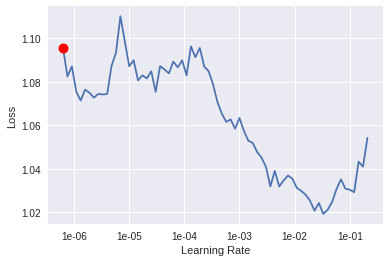

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, 1e-03)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,1.046075,1.171870,1.069960,-0.051140
2,1.004840,2.214992,1.439622,-0.978347
3,0.995194,3.408054,1.735249,-2.001757
4,0.986039,2.335965,1.511486,-1.263600
5,0.979440,1.609368,1.250008,-0.469016
6,0.980927,1.374520,1.161278,-0.241897
7,0.973034,1.282140,1.116200,-0.145895
8,0.971911,1.299222,1.112492,-0.140227
9,0.971090,1.231194,1.099571,-0.115515
10,0.973756,1.245120,1.091613,-0.097265


### See if dropout helps

In [0]:
learn = tabular_learner(data,
                        layers=[256,256],
                        loss_func=nn.MSELoss(),
                        ps=0.5,
                        metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


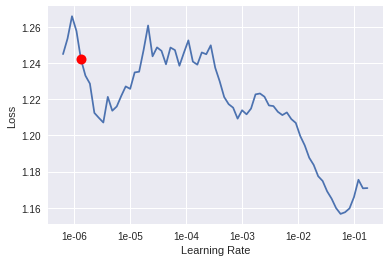

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(50, 1e-03)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,1.208421,1.195336,1.095394,-0.107128
2,1.192202,1.744247,1.331167,-0.683158
3,1.150593,2.459262,1.539505,-1.205892
4,1.120077,2.126997,1.449922,-0.952502
5,1.082642,1.911716,1.402984,-0.826664
6,1.060607,1.921583,1.322814,-0.646948
7,1.027458,1.580816,1.239128,-0.423093
8,1.004364,1.438123,1.166471,-0.257774
9,0.987131,1.241166,1.098059,-0.111512
10,0.971095,1.209013,1.085086,-0.085628


### Try more layers:

In [0]:
learn = tabular_learner(data,
                        layers=[1000,500],
                        loss_func=nn.MSELoss(),
                        ps=0.5,
                        metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


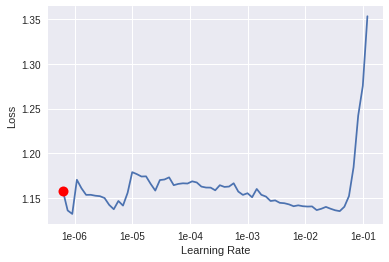

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, 1e-02)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,1.094608,1.173462,1.079243,-0.069525
2,1.021536,1.422489,1.196693,-0.347757
3,1.026171,7.423614,2.555690,-5.454298
4,1.010626,49.860397,6.418298,-45.135178
5,0.986105,98.605133,9.024231,-86.350357
6,0.975257,55.023087,6.754352,-49.255760
7,0.972559,2038.752197,40.666252,-1918.542114
8,0.964379,282.396973,15.492607,-259.592896
9,0.961433,129.388550,10.226062,-124.242188
10,0.959512,53.558624,6.710922,-51.352036


In [0]:
learn = tabular_learner(data,
                        layers=[256,256,256],
                        loss_func=nn.MSELoss(),
                        ps=0.5,
                        metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


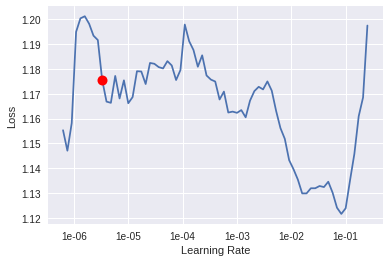

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-02)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,1.048806,1.154534,1.062430,-0.033572
2,1.001712,1.276100,1.154517,-0.216669
3,0.983240,1.211355,1.101576,-0.118719
4,0.979191,1.184141,1.078615,-0.064264
5,0.971282,1.180561,1.071414,-0.051718


### I can't even get the coefficient of determination above 0... that is bad. Time to go back to no standardization and try different architectures:

In [0]:
# Note that this isn't quite a fair comparison because I am not using 
# the same train/valid/test split! But I am just trying to get something working
data = (TabularList.from_df(pka_df, path='.',
                            cont_names=list(pka_df.columns)[1:-1])
        .split_by_idx(valid_idx=range(3000,pka_df.shape[0]))
        .label_from_df(cols='pka')
        .databunch()
       ) # no standardization anymore

In [0]:
learn = tabular_learner(data,
                        layers=[256,256],
                        loss_func=nn.MSELoss(),
                        ps=0.5,
                        metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02


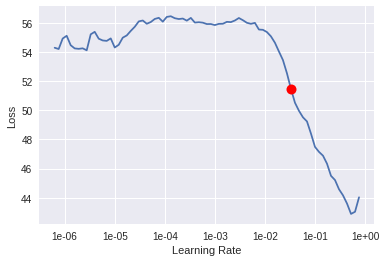

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-02)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,45.397617,19.455635,4.453118,-0.577790
2,22.083546,495.436523,21.548813,-39.140060
3,15.493986,39361.062500,189.054504,-2990.600586
4,13.219380,33131.933594,175.507370,-2576.547119
5,12.297815,24915.744141,149.535904,-1853.401611


### Again seems we are overfitting, but the train loss is not even low

In [0]:
learn = tabular_learner(data,
                        layers=[256],
                        loss_func=nn.MSELoss(),
                        ps=[0.5],
                        metrics=[root_mean_squared_error, r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02


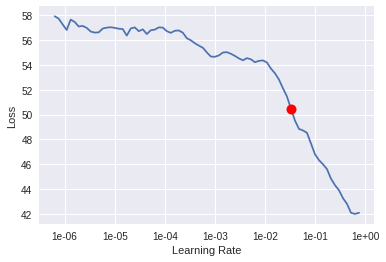

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-02)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,46.521828,22.541798,4.704718,-0.755416
2,22.361917,1757.030884,33.024479,-132.200119
3,15.600852,85516.148438,246.415863,-6881.403320
4,13.276751,119209.835938,285.797516,-9406.459961
5,12.372142,145369.656250,314.540924,-11181.870117


## Since nothing is working right now..., let's try one last (kind of crazy) approach




In [0]:
fps = [np.array(x) for x in pka_df.values[:,1:-1]]
fps[0]

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])

In [0]:
# pad the pictures a bit so we can make them square
fps = [np.hstack((x,np.zeros(68))) for x in fps]
fps[0]

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])

In [0]:
fps[0].shape

(2116,)

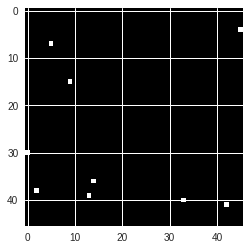

In [0]:
plt.imshow(fps[0].reshape((46,46)), cmap='gray')

In [0]:
!mkdir ./img_train/

In [0]:
import scipy
import imageio
from fastai.basics import *

for idx, fp in enumerate(fps):
  imageio.imwrite('./img_train/'+ str(idx)+'.png',255*fps[idx].reshape((46,46)).astype(np.uint8))

In [0]:
labels_df = pka_df[['pka']]
labels_df.rename(columns={'pka':'label'},inplace=True)
labels_df['name'] = ''
for idx, fp in enumerate(fps):
  labels_df.loc[idx,'name'] = './img_train/'+ str(idx)+'.png'

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [0]:
labels_df.head()

,label,name
0,6.35,./img_train/0.png
1,5.76,./img_train/1.png
2,5.82,./img_train/2.png
3,5.80,./img_train/3.png
4,9.43,./img_train/4.png


In [0]:
labels_df.to_csv('img_labels.csv')

In [0]:
from fastai.vision import *
from fastai.basics import *

In [0]:
data = (ImageItemList.from_csv('.', 'img_labels.csv', folder='img_train', suffix='.png')
        .random_split_by_pct()
        .label_from_df()
        .databunch())

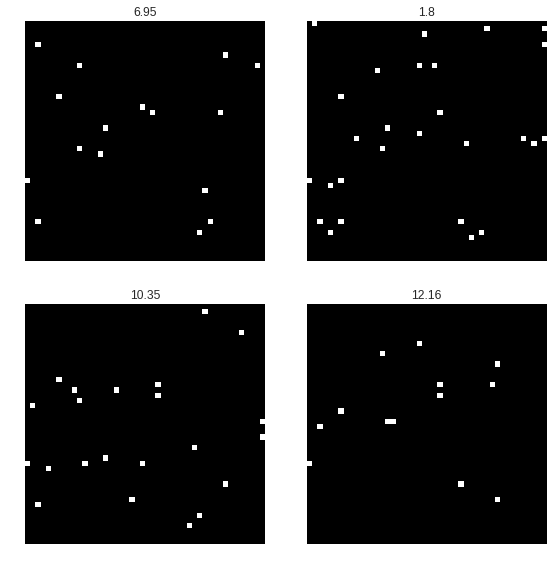

In [0]:
data.show_batch(rows=2)

In [0]:
learn = create_cnn(data,
                   models.resnet34,
                   loss_func=nn.MSELoss(),
                   metrics=[root_mean_squared_error, r2_score] )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


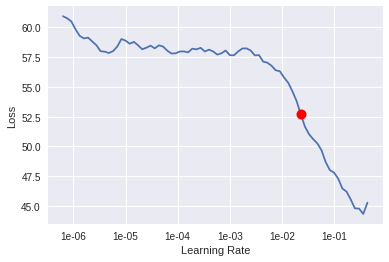

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,40.204990,13.137339,3.644295,-0.149620
2,21.242006,11.964149,3.443434,-0.024412
3,15.540550,11.761550,3.428998,-0.016092
4,13.513216,11.754834,3.421589,-0.011692
5,12.709634,11.740801,3.412781,-0.006403


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


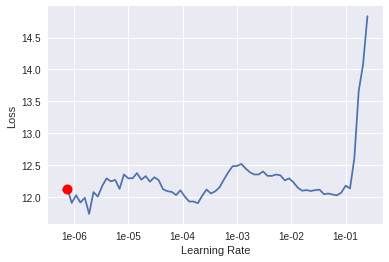

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score
1,11.922502,11.779028,3.426512,-0.014609
2,12.046463,11.790890,3.422046,-0.012432
3,12.092709,11.737434,3.405621,-0.002491
4,12.118666,11.745297,3.424965,-0.013573
5,12.132657,11.731516,3.422354,-0.012097
